# Modèle 1: l'équilibre radiatif

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure
from bokeh.io import output_file, output_notebook, show
from bokeh.layouts import layout, column, row
from bokeh.models import CustomJS, ColumnDataSource, Select, Legend,  Panel, Tabs, Label, LabelSet, Range1d, Div
from bokeh.models import Legend, LegendItem
from bokeh.models.widgets import DataTable, TableColumn, Slider, TextInput,CheckboxGroup
from bokeh.models.widgets import Panel, Tabs
from bokeh.transform import linear_cmap
from bokeh.palettes import Spectral6

In [2]:
def nakedplanet(alpha=0.3,L=1350):
    
    epsilon = 1
    sigma = 5.67E-8         # W/m2 K4
    Teq = ( L * (1 - alpha) / (4 * epsilon * sigma) ) ** (1/4) - 273.15
    
    return Teq

In [3]:
def nakedplanet1(alpha=0.3,L=1350):
    
    # PARAMETRES
    timeStep = 1            # years
    waterDepth = 4000       # meters
    Cp = waterDepth * 4.2E6 # J/K m2

    epsilon = 1
    sigma = 5.67E-8         # W/m2 K4
    Teq = ( L * (1 - alpha) / (4 * epsilon * sigma) ) ** (1/4)

    # INITIALISATION
    time = []
    temperature = []
    heatContent = []

    time.append(0)
    temperature.append(0)
    heatContent.append(Cp * temperature[0]) # J/m2
    heatIn = L * (1 - alpha) / 4
    heatOut = 0

    # INTEGRATION
    for it in range(1,2000):
        time.append(time[it-1] + timeStep)
        heatOut = epsilon * sigma * temperature[it-1]**4
        heatContent.append( heatContent[it-1] + (heatIn - heatOut) * timeStep * 3.14E7)
        temperature.append( heatContent[it] / Cp )

    return temperature, time

## Version Bokeh
## Jeu : Déterminer l'énergie solaire reçue et l'albédo des planètes du système solaire

In [4]:
tempMercure = nakedplanet(0.06,12300)
tempVenus = nakedplanet(0.7,3140)
tempTerre = nakedplanet(0.3,1360)
tempMars = nakedplanet(0.15,600)
tempJupiter = nakedplanet(0.42,50)
tempSaturne = nakedplanet(0.45,10)
tempUranus = nakedplanet(0.53,3.5)
tempNeptune = nakedplanet(0.66,1.5)


planets = ColumnDataSource(dict(

    name    = ['Mercure','Venus','         Terre','Mars','Jupiter','Saturne','Uranus','Neptune'],
    d       = [57.9,108.2,149.2,287.9,778.5,1434,2871,4495], # milliars de km
    albedo  = [0.06, 0.7, 0.3, 0.15, 0.42, 0.45, 0.53, 0.66],
    L       = [12300, 3140, 1360, 600, 50, 10, 3.5, 1.5], 
    temp_model = [tempMercure, tempVenus, tempTerre, tempMars, tempJupiter, tempSaturne, tempUranus, tempNeptune], 
    temp_true  = [179,462,15,-63,-163,-189,-220,-218],
    color = ['gold', 'fuchsia', 'lightblue', 'red', 'peru', 'burlywood', 'turquoise', 'mediumpurple'],
    #color_true = ['darkgoldenrod', 'fuchsia', 'blue', 'darkred', 'saddlebrown', 'chocolate', 'darkturquoise', 'purple']   

))


my_planet = ColumnDataSource(dict(
    
    name = ['Ma Planète'],
    d    = [2500],
    albedo = [0.5],
    L = [0.5],
    temp = [100],
    color = ['ghostwhite']
    
))

In [5]:
output_notebook()


# Paramétrage du slider 1 : énergie solaire
slider1 = Slider(start=0, end=12500, value=450, step=0.5, title='Energie solaire reçue [W/m²]')
handler1 = CustomJS(args=dict(source=my_planet),code="""
              var data = source.data
              var f = cb_obj.value
              var x = data['albedo']
              var y = data['L']            
              var z = data['temp']

              for (var i=0; i<x.length; i++){
                  y[i] = f
                  z[i] = ( f * (1 - x[i]) / (4 * 1 * 5.67E-8 ) ) ** (1/4) - 273.15
                  }
               source.change.emit();
              """)
slider1.js_on_change('value', handler1)

# Paramétrage du slider 2 : albédo
slider2 = Slider(start=0, end=1, value=0.5, step=0.01, title='Albédo')
handler2 = CustomJS(args=dict(source=my_planet),code="""
              var data = source.data
              var f = cb_obj.value
              var x = data['albedo']
              var y = data['L']            
              var z = data['temp']

              for (var i=0; i<x.length; i++){
                  x[i] = f
                  z[i] = ( y[i] * (1 - f) / (4 * 1 * 5.67E-8 ) ) ** (1/4) - 273.15
                  }
               source.change.emit();
              """)
slider2.js_on_change('value', handler2)



# Figure 1 : T(modèle) en fonction de l'énergie reçue
p1 = figure(     
    x_range=(0,3200),
    y_range=(-200,500),
    plot_width=400, 
    plot_height=400,
    title = 'Retrouvez l énergie reçue par chaque planète'
    )

p1.circle('L', 'temp', source=my_planet, color='color', size=10)
p1.circle('L', 'temp_model', source=planets, color='color', size=10)

label1 = LabelSet(x='L', y='temp_model', text='name', level='glyph',
              x_offset=4, y_offset=-1, source=planets, render_mode='canvas',
              text_font_size='8pt',text_color='color')

p1.add_layout(label1)

p1.xaxis.axis_label = 'Energie solaire reçue [W/m²]'
p1.xaxis.visible = False
p1.yaxis.axis_label = 'Température d' "'" 'équilibre [°C]'
p1.axis.axis_label_text_font_style = "bold"
p1.grid.grid_line_alpha = 0.3
p1.toolbar.autohide = True
tab1 = Panel(child=p1, title="Modèle")


# Figure 2: T(modèle) en fonction de l'albédo
p2 = figure(    
    x_range=(0,1),
    y_range=(-200,500),
    plot_width=400, 
    plot_height=400,
    title = 'Retrouvez l albédo de chaque planète'
)

p2.circle('albedo', 'temp', source=my_planet, color='color', size=10)
p2.circle('albedo', 'temp_model', source=planets, color='color', size=10)

label2 = LabelSet(x='albedo', y='temp_model', text='name', level='glyph',
              x_offset=4, y_offset=-1, source=planets, render_mode='canvas',
              text_font_size='8pt',text_color='color')
p2.add_layout(label2)

p2.xaxis.axis_label = 'Albédo'
p2.xaxis.visible = False
p2.yaxis.axis_label = 'Température d' "'" 'équilibre [°C]'
p2.axis.axis_label_text_font_style = "bold"
p2.grid.grid_line_alpha = 0.3
p2.toolbar.autohide = True
tab2 = Panel(child=p2, title="Modèle")


    
# Figure 3: T(réelle) en fonction de l'énergie reçue
p3 = figure(    
    x_range=(0,3200),
    y_range=(-200,500),
    plot_width=450, 
    plot_height=450)

p3.circle('L', 'temp_model', source=planets, color='color', size=10)
p3.circle('L', 'temp_true',  source=planets, line_color='color', fill_color="white",size=10)

label3 = LabelSet(x='L', y='temp_true', text='name', level='glyph',
              x_offset=4, y_offset=-1, source=planets, render_mode='canvas',
              text_font_size='8pt',text_color='color')
p3.add_layout(label3)

p3.xaxis.axis_label = 'Energie solaire reçue [W/m²]'
p3.yaxis.axis_label = 'Température d' "'" 'équilibre [°C]'
p3.axis.axis_label_text_font_style = "bold"
p3.grid.grid_line_alpha = 0.3
p3.toolbar.autohide = True

tab3 = Panel(child=p3, title="Réel")

# Figure 3: T(réelle) en fonction de l'albédo
p4 = figure(    
    x_range=(0,1),
    y_range=(-200,500),
    plot_width=450, 
    plot_height=450)

p4.circle('albedo', 'temp_model', source=planets, color='color', size=10)
p4.circle('albedo', 'temp_true',  source=planets, line_color='color', fill_color="white",size=10)

label4 = LabelSet(x='albedo', y='temp_true', text='name', level='glyph',
              x_offset=4, y_offset=-1, source=planets, render_mode='canvas',
              text_font_size='8pt',text_color='color')
p4.add_layout(label4)

p4.xaxis.axis_label = 'Albédo'
p4.yaxis.axis_label = 'Température d' "'" 'équilibre [°C]'
p4.axis.axis_label_text_font_style = "bold"
p4.grid.grid_line_alpha = 0.3
p4.toolbar.autohide = True

tab4 = Panel(child=p4, title="Réel")


tabA = Tabs(tabs=[ tab1, tab3 ])
tabB = Tabs(tabs=[ tab2, tab4 ])


#show(column(slider1,slider2,tabA), notebook_handle=True)



Loading BokehJS ...

In [6]:
output_notebook()

div = Div(text=""" <b> Energie solaire reçue </b>  
<i>(la bonne valeur est celle du slider que vous faites glisser)</i>""", width=200, height=50)

# Paramétrage du slider 1 : énergie solaire
slider1 = Slider(start=0, end=20000, value=0.1, step=0.1, title='')
slider2 = Slider(start=0, end=1000, value=0.1, step=0.01, title='')
slider3 = Slider(start=0, end=10, value=0.1, step=0.001, title='')

handler1 = CustomJS(args=dict(source=my_planet),code="""
              var data = source.data
              var f = cb_obj.value
              var x = data['albedo']
              var y = data['L']            
              var z = data['temp']
              var d = data['d']

              for (var i=0; i<x.length; i++){
                  y[i] = f
                  z[i] = ( f * (1 - x[i]) / (4 * 1 * 5.67E-8 ) ) ** (1/4) - 273.15
                  d[i] = 5535 / f**(1/2) 
                  }
               source.change.emit();
              """)

slider1.js_on_change('value', handler1)
slider2.js_on_change('value', handler1)
slider3.js_on_change('value', handler1)

div2 = Div(text=""" <b> Albédo planétaire </b>""", width=200, height=10)

# Paramétrage du slider 4 : albédo
slider4 = Slider(start=0, end=1, value=0.5, step=0.005, title='')
handler4 = CustomJS(args=dict(source=my_planet),code="""

      var data = source.data
      var f = cb_obj.value
      var x = data['albedo']
      var y = data['L']            
      var z = data['temp']
      var d = data['d']

      for (var i=0; i<x.length; i++){
          x[i] = f
          z[i] = ( y[i] * (1 - f) / (4 * 1 * 5.67E-8 ) ) ** (1/4) - 273.15
          }
       source.change.emit();
      """)
slider4.js_on_change('value', handler4)


div3 = Div(text=""" <i> N'hésitez pas à utiliser les boutons à droite du graphique pour zoomer. </i>"""
           , width=250, height=10)

p1 = figure(     
    x_range=(0,5000),
    y_range=(-300,400),
    plot_width=550, 
    plot_height=300,
    )

p1.circle('d', 'temp', source=my_planet, color='color', size=10)
p1.circle('d', 'temp_model', source=planets, color='color', size=10)

label1 = LabelSet(x='d', y='temp_model', text='name', level='glyph',
              x_offset=5, y_offset=15, source=planets, render_mode='canvas',
              text_font_size='8pt',text_color='color')

p1.add_layout(label1)

p1.xaxis.visible = True
p1.xaxis.axis_label = 'Distance au Soleil en milliards de km'
p1.yaxis.visible = False
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

p1.toolbar.autohide = False

p1.outline_line_width = 10
p1.outline_line_color = "black"


p1.background_fill_alpha = 1
p1.background_fill_color = "midnightblue"

show(row(column(div,slider1,slider2,slider3,div2,slider4,div3),p1), notebook_handle=True)



Loading BokehJS ...

In [7]:
output_notebook()

# Paramétrage du slider 1 : énergie solaire
div1 = Div(text=""" <b> Energie solaire reçue en W/m² </b>""", width=200, height=10)
slider1 = Slider(start=0, end=20000, value=0.1, step=0.1, title='')
slider2 = Slider(start=0, end=1000, value=0.1, step=0.01, title='')
slider3 = Slider(start=0, end=10, value=0.1, step=0.001, title='')

handler1 = CustomJS(args=dict(source=my_planet),code="""
              var data = source.data
              var f = cb_obj.value
              var x = data['albedo']
              var y = data['L']            
              var z = data['temp']
              var d = data['d']

              for (var i=0; i<x.length; i++){
                  y[i] = f
                  z[i] = ( f * (1 - x[i]) / (4 * 1 * 5.67E-8 ) ) ** (1/4) - 273.15
                  d[i] = 5535 / f**(1/2) 
                  }
               source.change.emit();
              """)

slider1.js_on_change('value', handler1)
slider2.js_on_change('value', handler1)
slider3.js_on_change('value', handler1)

div1_bis = Div(text=""" <i>La bonne valeur est celle du slider que vous venez de faire glisser.</i>""", width=400, height=20)

# Paramétrage du slider 4 : albédo
div2 = Div(text=""" <b> Albédo planétaire </b>""", width=200, height=10)
slider4 = Slider(start=0, end=1, value=0.5, step=0.005, title='')
handler2 = CustomJS(args=dict(source=my_planet),code="""

      var data = source.data
      var f = cb_obj.value
      var x = data['albedo']
      var y = data['L']            
      var z = data['temp']
      var d = data['d']

      for (var i=0; i<x.length; i++){
          x[i] = f
          z[i] = ( y[i] * (1 - f) / (4 * 1 * 5.67E-8 ) ) ** (1/4) - 273.15
          }
       source.change.emit();
      """)

slider4.js_on_change('value', handler2)


div2_bis = Div(text=""" <i>N'hésitez pas à bouger le graphique et à zoomer ! </i>""", width=400, height=20)


p1 = figure(     
    x_range=(0,5000),
    y_range=(-300,400),
    plot_width=550, 
    plot_height=300,
    )

p1.circle('d', 'temp', source=my_planet, color='color', size=10)
p1.circle('d', 'temp_model', source=planets, color='color', size=10)

label1 = LabelSet(x='d', y='temp_model', text='name', level='glyph',
              x_offset=5, y_offset=15, source=planets, render_mode='canvas',
              text_font_size='8pt',text_color='color')

p1.add_layout(label1)

p1.xaxis.visible = True
p1.xaxis.axis_label = 'Distance au Soleil en milliards de km'
p1.yaxis.visible = False
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

p1.toolbar.autohide = False

p1.outline_line_width = 10
p1.outline_line_color = "black"


p1.background_fill_alpha = 1
p1.background_fill_color = "midnightblue"

show(column(div1,slider1,slider2,slider3,div1_bis,div2,slider4,div2_bis,p1), notebook_handle=True)


Loading BokehJS ...

## Illustration : équilibre radiatif

In [8]:
temperature, time = nakedplanet1(0.5,3500)

for i in range(2000):
    temperature[i] = temperature[i] - 273.15

my_planet = ColumnDataSource(dict(
  
    time = time,
    temperature = temperature,
    
))

mapper = linear_cmap(field_name='temperature', palette=Spectral6 ,low=min(temperature) ,high=max(temperature))

output_file("equilibre_radiatif.html")

p1 = figure(plot_width=800, plot_height=400 )

p1.circle('time', 'temperature',line_color=mapper,color=mapper,fill_alpha=1, size=4, source=my_planet)

p1.xaxis.visible = True
p1.xaxis.axis_label = 'Temps [unité arbitraire]'
p1.yaxis.visible = True
p1.yaxis.axis_label = 'Température [°C]'
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

p1.toolbar.autohide = False

p1.outline_line_width = 1
p1.outline_line_color = "black"

p1.background_fill_alpha = 1
p1.background_fill_color = "white"

show(p1, notebook_handle=True)

In [9]:
temperature1, time = nakedplanet1(0.1,3500)
temperature2, time = nakedplanet1(0.9,3500)

for i in range(2000):
    temperature1[i] = temperature1[i] - 273.15
    temperature2[i] = temperature2[i] - 273.15
    

output_notebook()

p1 = figure(plot_width=800, plot_height=400 )

r1=p1.line(time, temperature1, line_color="saddlebrown" , line_width=2)
r2=p1.line(time, temperature2, line_color="paleturquoise", line_width=2)

legend = Legend(items=[
    LegendItem(label="Albédo = 0.1", renderers=[r1], index=0),
    LegendItem(label="Albédo = 0.9", renderers=[r2], index=1),
])
#p1.add_layout(legend)

p1.xaxis.visible = True
p1.xaxis.axis_label = 'Temps [unité arbitraire]'
p1.yaxis.visible = True
p1.yaxis.axis_label = 'Température [°C]'
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

p1.toolbar.autohide = False

p1.outline_line_width = 1
p1.outline_line_color = "black"

p1.background_fill_alpha = 1
p1.background_fill_color = "white"


show(p1, notebook_handle=True)

Loading BokehJS ...

## Version Jupiter 

Text(0, 0.5, "Température d'équilibre planétaire [K]")

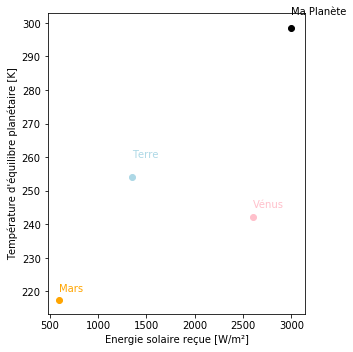

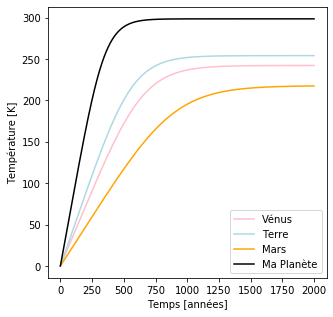

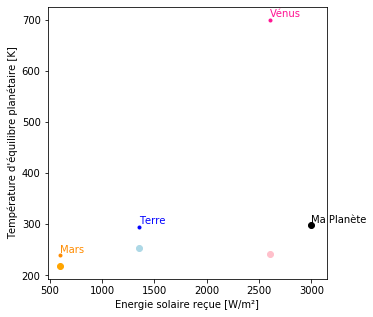

In [16]:
## PARAMETRES DE MA PLANETE
alpha_random = 0.4
L_random = 3000
tempRandom, time = nakedplanet1(alpha_random,L_random)

## LES AUTRES PLANETES
tempEarth, time1 = nakedplanet1(0.3,1350)
tempVenus, time2 = nakedplanet1(0.7,2600)
tempMars, time3 = nakedplanet1(0.15,600)

# FIGURE1 : énergie solaire reçue VS température d'équilibre
plt.figure(figsize=(5,5))
plt.scatter(600,tempMars[-1],color='orange')
plt.text(600,220,'Mars',color='orange')
plt.scatter(1350,tempEarth[-1],color='lightblue')
plt.text(1350,260,'Terre',color='lightblue')
plt.scatter(2600,tempVenus[-1],color='pink')
plt.text(2600,245,'Vénus',color='pink')
plt.scatter(L_random,tempRandom[-1],color='black')
plt.text(L_random,tempRandom[-1]+4,'Ma Planète',color='black')
plt.xlabel('Energie solaire reçue [W/m²]')
plt.ylabel('Température d' "'" 'équilibre planétaire [K]')
plt.tight_layout()


# FIGURE2 : temps de convergence vers la température d'équilibre
plt.figure(figsize=(5,5))
plt.plot(time,tempVenus,'pink',label='Vénus')
plt.plot(time,tempEarth,'lightblue',label='Terre')
plt.plot(time,tempMars,'orange',label='Mars')
plt.plot(time,tempRandom,'black',label='Ma Planète')
plt.xlabel('Temps [années]')
plt.ylabel('Température [K]')
plt.legend(loc='best')


# FIGURE 3: comparaison des températures évaluées par le modèle et des températures réelles
plt.figure(figsize=(5,5))
plt.scatter(600,tempMars[-1],color='orange')
plt.scatter(600,240,marker='.',color='darkorange')
plt.text(600,245,'Mars',color='darkorange')
plt.scatter(1350,tempEarth[-1],color='lightblue')
plt.scatter(1350,295,marker='.',color='blue')
plt.text(1350,300,'Terre',color='blue')
plt.scatter(2600,tempVenus[-1],color='pink')
plt.scatter(2600,700,marker='.',color='deeppink')
plt.text(2600,705,'Vénus',color='deeppink')
plt.scatter(L_random,tempRandom[-1],color='black')
plt.text(L_random,tempRandom[-1]+4,'Ma Planète',color='black')
plt.xlabel('Energie solaire reçue [W/m²]')
plt.ylabel('Température d' "'" 'équilibre planétaire [K]')
